# Image Classification with SVMs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
import csv

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection importRandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.svm import LinearSVC


2023-04-19 04:48:34.320505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 04:48:34.927555: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-19 04:48:44.028454: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-19 04:48:44.028910: W tensorflow/strea

In [2]:
os.cpu_count()

16

### Load Dataset

In [3]:
%%time

# Load the compressed array from disk
images_mini = np.load('CNN_Xs_downsample_forvgg16.npz')['data']

CPU times: user 16 s, sys: 1.35 s, total: 17.4 s
Wall time: 17.4 s


In [4]:
# load the labels from disk
with open('CNN_labels_downsampled_forvgg16.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]
    y_mini= np.array(labels_mini)

In [5]:
print('images_mini.shape:', images_mini.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (5600, 224, 224, 3)

number of labels: 5600

number of positive cancer cases: 600


### Normalize

In [6]:
print('Original max pixel value:', images_mini.max())
print('Confirm min pixel value is 0:', images_mini.min())

Original max pixel value: 255.0
Confirm min pixel value is 0: 0.0


In [7]:
#Normalize image pixel values
images_mini_norm = images_mini / images_mini.max() 

In [8]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 1.0
Confirm min pixel value is 0: 0.0


### Reshape

In [9]:
images_mini_norm.shape

(5600, 224, 224, 3)

In [10]:
arr_mean = np.mean(images_mini_norm, axis=-1)
arr_mean.shape
resized_images_mini = np.expand_dims(arr_mean, axis=-1)
resized_images_mini.shape

(5600, 224, 224, 1)

In [11]:
print('Original max pixel value:', resized_images_mini.max())
print('Confirm min pixel value is 0:', resized_images_mini.min())

Original max pixel value: 1.0
Confirm min pixel value is 0: 0.0


## Settings

In [12]:
random_state = 1234

In [13]:
random.seed(random_state)
tf.random.set_seed(random_state)
np.random.seed(random_state)

### Inputs

In [14]:
X= resized_images_mini
y = y_mini

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# reshape
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))

## Build Model

In [16]:
param_dist = {
    'C': np.logspace(-4, 4, 5),
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l1', 'l2'],
    'dual': [False],
    'tol': np.logspace(-6, -1, 5)
}

In [17]:
svm_classifier = LinearSVC()

In [18]:
X_train.shape

(4480, 50176)

In [19]:
y_train.shape

(4480,)

In [20]:
grid_search = RandomizedSearchCV(
    svm_classifier, 
    param_distributions=param_dist, 
    cv=StratifiedKFold(5),
    scoring='f1',
    n_jobs=10,
    verbose=20,
    n_iter=100,
    return_train_score=True,
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 5/5; 2/20] START C=0.01, dual=False, loss=squared_hinge, penalty=l2, tol=1e-06
[CV 5/5; 2/20] END C=0.01, dual=False, loss=squared_hinge, penalty=l2, tol=1e-06;, score=(train=0.951, test=0.033) total time= 2.4min
[CV 5/5; 11/20] START C=0.01, dual=False, loss=squared_hinge, penalty=l1, tol=0.005623413251903491
[CV 5/5; 11/20] END C=0.01, dual=False, loss=squared_hinge, penalty=l1, tol=0.005623413251903491;, score=(train=0.000, test=0.000) total time=   7.0s
[CV 3/5; 12/20] START C=1.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.1
[CV 3/5; 12/20] END C=1.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.1;, score=(train=0.971, test=0.059) total time= 1.2min
[CV 3/5; 17/20] START C=10000.0, dual=False, loss=squared_hinge, penalty=l2, tol=1.778279410038923e-05
[CV 3/5; 17/20] END C=10000.0, dual=False, loss=squared_hinge, penalty=l2, tol=1.778279410038923e-05;, score=(train=1.000, test=0.139) total time= 1.7min
[C

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV 3/5; 2/20] START C=0.01, dual=False, loss=squared_hinge, penalty=l2, tol=1e-06
[CV 3/5; 2/20] END C=0.01, dual=False, loss=squared_hinge, penalty=l2, tol=1e-06;, score=(train=0.957, test=0.050) total time= 2.6min
[CV 5/5; 12/20] START C=1.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.1
[CV 5/5; 12/20] END C=1.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.1;, score=(train=0.958, test=0.073) total time=  56.4s
[CV 2/5; 17/20] START C=10000.0, dual=False, loss=squared_hinge, penalty=l2, tol=1.778279410038923e-05
[CV 2/5; 17/20] END C=10000.0, dual=False, loss=squared_hinge, penalty=l2, tol=1.778279410038923e-05;, score=(train=1.000, test=0.136) total time= 1.9min
[CV 4/5; 19/20] START C=100.0, dual=False, loss=squared_hinge, penalty=l1, tol=1.778279410038923e-05
[CV 4/5; 19/20] END C=100.0, dual=False, loss=squared_hinge, penalty=l1, tol=1.778279410038923e-05;, score=(train=1.000, test=0.089) total time= 8.8min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV 1/5; 1/20] START C=1.0, dual=False, loss=hinge, penalty=l1, tol=1e-06.......
[CV 1/5; 1/20] END C=1.0, dual=False, loss=hinge, penalty=l1, tol=1e-06;, score=(train=nan, test=nan) total time=   2.5s
[CV 5/5; 3/20] START C=10000.0, dual=False, loss=hinge, penalty=l1, tol=1.778279410038923e-05
[CV 5/5; 3/20] END C=10000.0, dual=False, loss=hinge, penalty=l1, tol=1.778279410038923e-05;, score=(train=nan, test=nan) total time=   1.3s
[CV 5/5; 4/20] START C=100.0, dual=False, loss=hinge, penalty=l1, tol=1.778279410038923e-05
[CV 5/5; 4/20] END C=100.0, dual=False, loss=hinge, penalty=l1, tol=1.778279410038923e-05;, score=(train=nan, test=nan) total time=   1.9s
[CV 5/5; 5/20] START C=10000.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.005623413251903491
[CV 5/5; 5/20] END C=10000.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.005623413251903491;, score=(train=1.000, test=0.083) total time= 1.5min
[CV 1/5; 6/20] START C=100.0, dual=False, loss=hinge, penalty=l2, tol=0.0056234

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV 1/5; 2/20] START C=0.01, dual=False, loss=squared_hinge, penalty=l2, tol=1e-06
[CV 1/5; 2/20] END C=0.01, dual=False, loss=squared_hinge, penalty=l2, tol=1e-06;, score=(train=0.966, test=0.033) total time= 2.1min
[CV 3/5; 10/20] START C=1.0, dual=False, loss=hinge, penalty=l1, tol=0.00031622776601683794
[CV 3/5; 10/20] END C=1.0, dual=False, loss=hinge, penalty=l1, tol=0.00031622776601683794;, score=(train=nan, test=nan) total time=   1.0s
[CV 5/5; 10/20] START C=1.0, dual=False, loss=hinge, penalty=l1, tol=0.00031622776601683794
[CV 5/5; 10/20] END C=1.0, dual=False, loss=hinge, penalty=l1, tol=0.00031622776601683794;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5; 11/20] START C=0.01, dual=False, loss=squared_hinge, penalty=l1, tol=0.005623413251903491
[CV 2/5; 11/20] END C=0.01, dual=False, loss=squared_hinge, penalty=l1, tol=0.005623413251903491;, score=(train=0.000, test=0.000) total time=   6.6s
[CV 3/5; 11/20] START C=0.01, dual=False, loss=squared_hinge, penalty=l1

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[CV 4/5; 1/20] START C=1.0, dual=False, loss=hinge, penalty=l1, tol=1e-06.......
[CV 4/5; 1/20] END C=1.0, dual=False, loss=hinge, penalty=l1, tol=1e-06;, score=(train=nan, test=nan) total time=   1.6s
[CV 1/5; 3/20] START C=10000.0, dual=False, loss=hinge, penalty=l1, tol=1.778279410038923e-05
[CV 1/5; 3/20] END C=10000.0, dual=False, loss=hinge, penalty=l1, tol=1.778279410038923e-05;, score=(train=nan, test=nan) total time=   1.7s
[CV 1/5; 4/20] START C=100.0, dual=False, loss=hinge, penalty=l1, tol=1.778279410038923e-05
[CV 1/5; 4/20] END C=100.0, dual=False, loss=hinge, penalty=l1, tol=1.778279410038923e-05;, score=(train=nan, test=nan) total time=   1.2s
[CV 1/5; 5/20] START C=10000.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.005623413251903491
[CV 1/5; 5/20] END C=10000.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.005623413251903491;, score=(train=1.000, test=0.091) total time= 1.7min
[CV 3/5; 9/20] START C=0.01, dual=False, loss=squared_hinge, penalty=l2, tol=0.

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
55 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 272, in fit
    sample_weight=sample_weight,
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/opt/con

[CV 4/5; 2/20] START C=0.01, dual=False, loss=squared_hinge, penalty=l2, tol=1e-06
[CV 4/5; 2/20] END C=0.01, dual=False, loss=squared_hinge, penalty=l2, tol=1e-06;, score=(train=0.959, test=0.064) total time= 2.7min
[CV 1/5; 13/20] START C=100.0, dual=False, loss=hinge, penalty=l1, tol=0.005623413251903491
[CV 1/5; 13/20] END C=100.0, dual=False, loss=hinge, penalty=l1, tol=0.005623413251903491;, score=(train=nan, test=nan) total time=   1.2s
[CV 2/5; 13/20] START C=100.0, dual=False, loss=hinge, penalty=l1, tol=0.005623413251903491
[CV 2/5; 13/20] END C=100.0, dual=False, loss=hinge, penalty=l1, tol=0.005623413251903491;, score=(train=nan, test=nan) total time=   1.2s
[CV 3/5; 13/20] START C=100.0, dual=False, loss=hinge, penalty=l1, tol=0.005623413251903491
[CV 3/5; 13/20] END C=100.0, dual=False, loss=hinge, penalty=l1, tol=0.005623413251903491;, score=(train=nan, test=nan) total time=   1.1s
[CV 4/5; 13/20] START C=100.0, dual=False, loss=hinge, penalty=l1, tol=0.00562341325190349

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LinearSVC(), n_iter=20, n_jobs=10,
                   param_distributions={'C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                                        'dual': [False],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'penalty': ['l1', 'l2'],
                                        'tol': array([1.00000000e-06, 1.77827941e-05, 3.16227766e-04, 5.62341325e-03,
       1.00000000e-01])},
                   return_train_score=True, scoring='f1', verbose=20)

[CV 5/5; 1/20] START C=1.0, dual=False, loss=hinge, penalty=l1, tol=1e-06.......
[CV 5/5; 1/20] END C=1.0, dual=False, loss=hinge, penalty=l1, tol=1e-06;, score=(train=nan, test=nan) total time=   1.7s
[CV 3/5; 3/20] START C=10000.0, dual=False, loss=hinge, penalty=l1, tol=1.778279410038923e-05
[CV 3/5; 3/20] END C=10000.0, dual=False, loss=hinge, penalty=l1, tol=1.778279410038923e-05;, score=(train=nan, test=nan) total time=   1.7s
[CV 3/5; 4/20] START C=100.0, dual=False, loss=hinge, penalty=l1, tol=1.778279410038923e-05
[CV 3/5; 4/20] END C=100.0, dual=False, loss=hinge, penalty=l1, tol=1.778279410038923e-05;, score=(train=nan, test=nan) total time=   1.3s
[CV 3/5; 5/20] START C=10000.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.005623413251903491
[CV 3/5; 5/20] END C=10000.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.005623413251903491;, score=(train=1.000, test=0.139) total time= 1.8min
[CV 4/5; 9/20] START C=0.01, dual=False, loss=squared_hinge, penalty=l2, tol=0.

In [ ]:
model_name = 'linearsvc'

# convert the results to a pandas DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# save the results to a CSV file
cv_results.to_csv(f'results/{model_name}_crossvalidation_results.csv', index=False)

In [21]:
# print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'tol': 1.778279410038923e-05, 'penalty': 'l2', 'loss': 'squared_hinge', 'dual': False, 'C': 10000.0}
Best Score: 0.12359286574112013


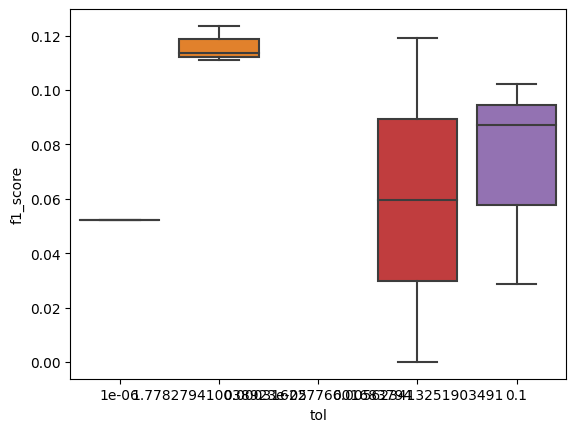

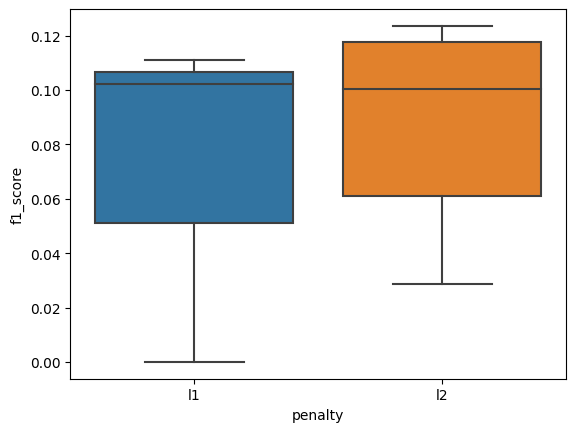

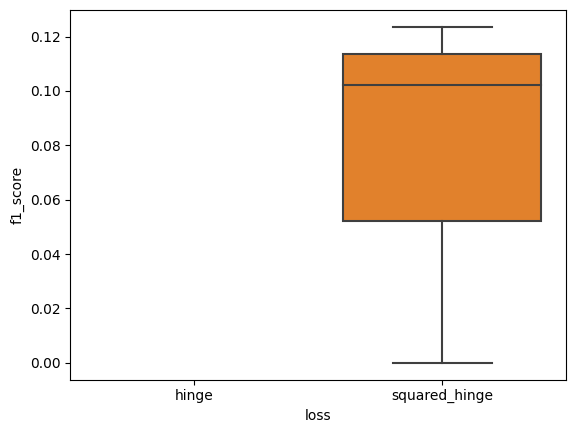

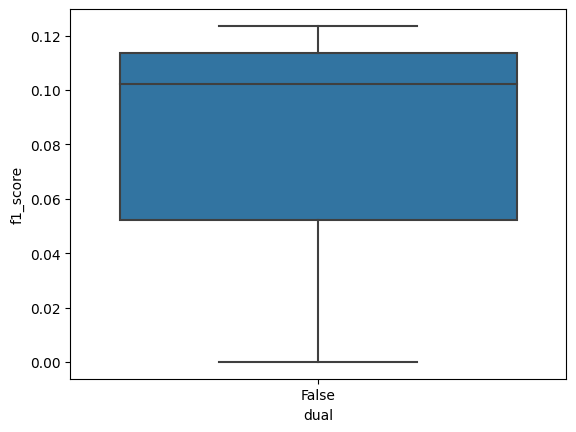

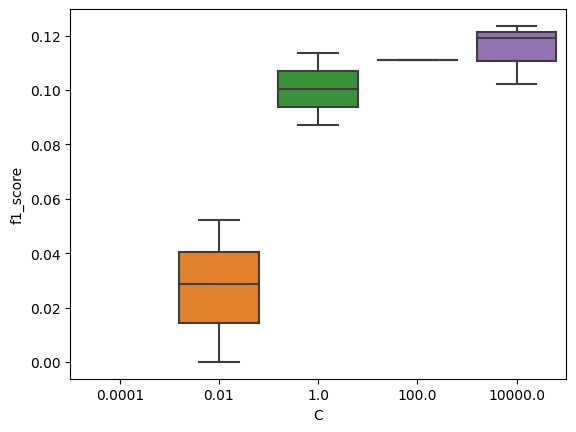

In [23]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']


import seaborn as sns
for param_name in params[0].keys():
    # Extract the scores and hyperparameter values for the current parameter
    
    values = [pdict[param_name] for pdict in params]
    
    # Create a boxplot
    plt.figure()
    sns.boxplot(x=values, y=scores)
    plt.xlabel(param_name)
    plt.ylabel('f1_score')
    plt.show()

### Scoring

In [24]:
# grid_search.best_params_
hyperparam = {'tol': 1.778279410038923e-05, 'penalty': 'l2', 'loss': 'squared_hinge', 'dual': False, 'C': 10000.0}

In [25]:
tuned_clf = LinearSVC(
    **hyperparam
)

In [26]:
tuned_clf.fit(X_train, y_train)

LinearSVC(C=10000.0, dual=False, tol=1.778279410038923e-05)

In [22]:
train_roc = tuned_clf.score(X_train, y_train)
print(f"Train acc score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = tuned_clf.score(X_test, y_test)
print(f"Test acc score: {test_roc:.3f}")

Train ROC_AUC score: 0.988
Test ROC_AUC score: 0.874


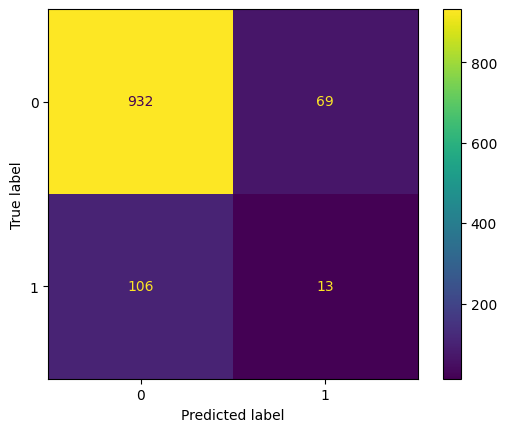

In [27]:
y_pred_train = tuned_clf.predict(X_train)
y_pred_test = tuned_clf.predict(X_test)


In [28]:
from sklearn.metrics import precision_score, recall_score

train_roc = precision_score(y_train, y_pred_train)
print(f"Train precision score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = precision_score(y_test, y_pred_test)
print(f"Test precision score: {test_roc:.3f}")



Train precision score: 1.000
Test precision score: 0.159
Train recall score: 1.000
Test recall score: 0.109


In [ ]:
train_roc = recall_score(y_train, y_pred_train)
print(f"Train recall score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = recall_score(y_test, y_pred_test)
print(f"Test recall score: {test_roc:.3f}")

In [29]:
train_roc = roc_auc_score(y_train, y_pred_train)
print(f"Train ROC_AUC score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = roc_auc_score(y_test, y_pred_test)
print(f"Test ROC_AUC score: {test_roc:.3f}")

Train ROC_AUC score: 1.000
Test ROC_AUC score: 0.520


In [30]:
train_roc = f1_score(y_train, y_pred_train)
print(f"Train f1 score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = f1_score(y_test, y_pred_test)
print(f"Test f1 score: {test_roc:.3f}")

Train f1 score: 1.000
Test f1 score: 0.129


In [ ]:
cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tuned_clf.classes_
)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train, y_pred_train))

In [ ]:
print(classification_report(y_test, y_pred_test))